<a href="https://colab.research.google.com/github/CarysDT/Colab-Notebook/blob/main/Copy_of_Unit4ExerciesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [4]:
#load the data from my github page.
#cs stands for chemical shift data
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
#I could have put the url string directly into pd.read_csv()
cs_data = pd.read_csv(url_cs)

In [5]:
cs_data

,ID,aa,theo,exp,cat
0,1BM8,ILE,61.18,58.27,Non-Polar
1,1BM8,TYR,56.95,56.18,Polar
2,1BM8,SER,56.35,56.84,Polar
3,1BM8,ALA,51.96,51.01,Special
4,1BM8,ARG,56.54,54.64,Charged
...,...,...,...,...,...
1771,1KS9,LYS,55.79,57.51,Charged
1772,1KS9,ARG,58.91,59.02,Charged
1773,1KS9,LYS,59.49,58.92,Charged
1774,1KS9,GLU,59.48,58.36,Charged


In [6]:

#element wise subtraction
diff_TminusE = cs_data.theo - cs_data.exp
#adds a column called 'diff_TminusE' as the fifth column of cs_data
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)

In [7]:
aa_encode = pd.Categorical(cs_data['aa'])
aa_encode
aa_idx = aa_encode.codes
aa_idx
#stores the category names in a dictionary
#this dictionary format is required
#for pymc to properly read the categories
aa_coords = {"aa": aa_encode.categories}
aa_coords

{'aa': Index(['ALA', 'ARG', 'ASN', 'ASP', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU',
        'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL'],
       dtype='object')}

In [8]:
with pm.Model(coords=aa_coords) as cs_h_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.StudentT('μ_mu', mu = 0, sigma = 10, nu = 10)
    μ_sd = pm.HalfStudentT('μ_sd', sigma = 10, nu = 10)
    μ_nu = pm.HalfStudentT('μ_nu', nu=10)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.StudentT('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "aa", nu=μ_nu)

    σ = pm.HalfStudentT('σ', sigma = 10,
                      dims = "aa", nu=10)
    ν = pm.HalfStudentT('ν', sigma = 10,
                      dims = "aa", nu=10)

    #likelihood; same as before
    y = pm.StudentT('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                    nu = ν[aa_idx],
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_h = pm.sample()

Output()

Output()

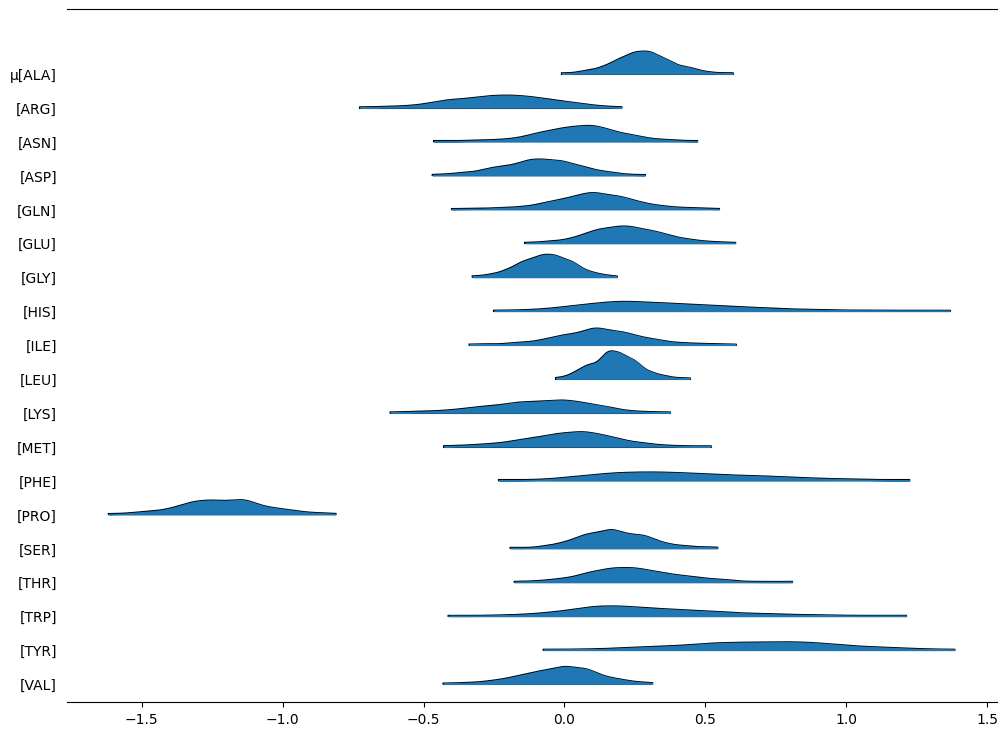

In [10]:
axes = az.plot_forest(idata_cs_h, kind="ridgeplot",
                      var_names='μ',
                      combined=True, figsize=(12, 9), hdi_prob=0.997)

**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

Output()

<Axes: xlabel='y'>

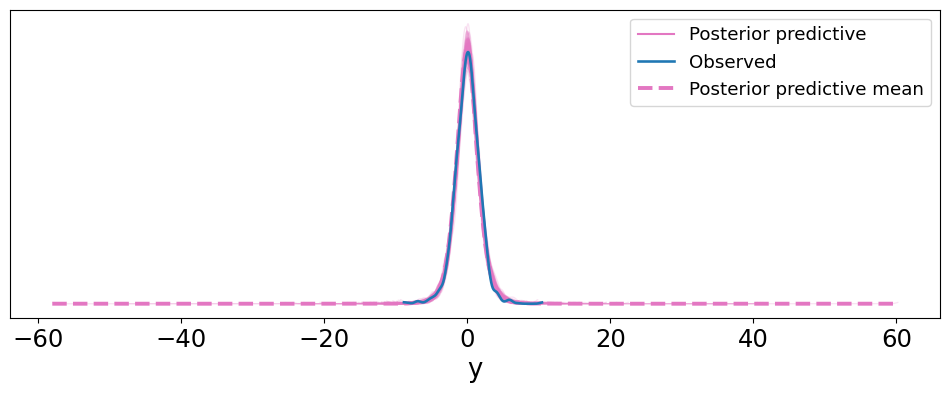

In [10]:
pm.sample_posterior_predictive(idata_cs_h , model=cs_h_model, extend_inferencedata=True)
az.plot_ppc(idata_cs_h, num_pp_samples=100, figsize=(12, 4), colors=["C6", "C0", "C6"])

In [11]:
with pm.Model(coords=aa_coords) as cs_nh_model:
    #priors
    #dims="aa" means to apply the prior seperately to each amino acid
    μ = pm.Normal('μ', mu=0, sigma=10,
                  dims="aa")
    σ = pm.HalfNormal('σ', sigma=10,
                      dims="aa")

    #The idx variable tells my model which diffs belong to the same amino acid
    #this will cause my model to generate a posterior for each amino acid
    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed=cs_data.diff_TminusE)

    #cs for chemshift, nh for nonheirarchical
    idata_cs_nh = pm.sample()

Output()

Output()

Output()

<Axes: xlabel='y'>

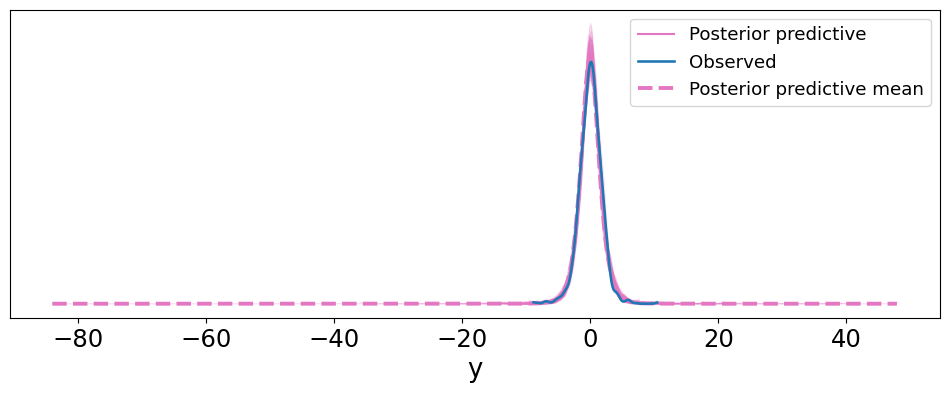

In [12]:
pm.sample_posterior_predictive(idata_cs_h , model=cs_h_model, extend_inferencedata=True)
az.plot_ppc(idata_cs_h, num_pp_samples=100, figsize=(12, 4), colors=["C6", "C0", "C6"])

The StudentT fit better and had a more narrow slope.

**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [25]:
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'

#Turns the position column into a categorical variable
sccr_data = pd.read_csv(url_sccr)
sccr_data

,name,position,goals,shots
0,Aaron Connolly,FW,5,59
1,Aaron Cresswell,DF,4,69
2,Aaron Hunt,MF,3,30
3,Aaron Lennon,MF,1,5
4,Aaron Leya Iseka,FW,10,76
...,...,...,...,...
2677,Óscar Mingueza,DF,2,12
2678,Óscar Plano,MF,12,124
2679,Óscar Rodríguez,MF,13,133
2680,Óscar Trejo,MF,1,20


In [26]:
sccr_data_noGK=sccr_data.query('position!="GK"')

In [27]:
sccr_data['position']=sccr_data['position'].astype("category")
sccr_data_noGK['position']=sccr_data_noGK['position'].astype("category")

<ipython-input-27-0c4d5c012280>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sccr_data_noGK['position']=sccr_data_noGK['position'].astype("category")


In [24]:
pos_idx = sccr_data.position.cat.codes.values

#an array of the four strings that represent position
pos_codes = sccr_data.position.cat.categories

#puts coords in a dict, so pymc can read them
sccr_coords = {"pos": pos_codes}

In [23]:
with pm.Model(coords = sccr_coords) as sccr_model:
    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = 0.090, nu = 55, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

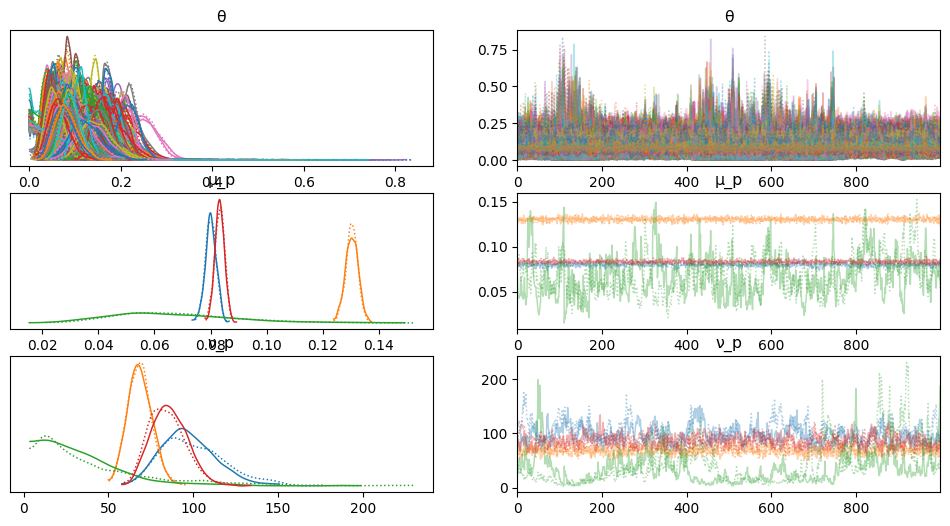

In [16]:
az.plot_trace(idata_sccr)

**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

array([<Axes: >], dtype=object)

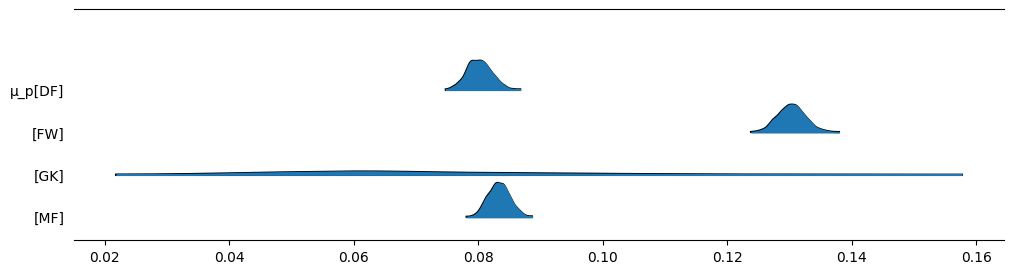

In [28]:
az.plot_forest(idata_sccr, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

The GK data is much more spread out due to the fact that without the hyper priors the raw data is more impactful, and is less defined with many outliers, therefore it spreads out a lot more.

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [13]:
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'

#Turns the position column into a categorical variable
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})
pos_idx = sccr_data.position.cat.codes.values
pos_codes= sccr_data.position.cat.categories
sccr_coords={"pos":pos_codes}
sccr_data

,name,position,goals,shots
0,Aaron Connolly,FW,5,59
1,Aaron Cresswell,DF,4,69
2,Aaron Hunt,MF,3,30
3,Aaron Lennon,MF,1,5
4,Aaron Leya Iseka,FW,10,76
...,...,...,...,...
2677,Óscar Mingueza,DF,2,12
2678,Óscar Plano,MF,12,124
2679,Óscar Rodríguez,MF,13,133
2680,Óscar Trejo,MF,1,20


In [30]:
pos_idx_ngk = sccr_data_ngk.position.cat.codes.values

In [14]:
gk_ind_list = list(sccr_data.query('position == "GK"').index)
print(gk_ind_list)

[6, 59, 62, 63, 66, 93, 96, 99, 100, 107, 108, 113, 123, 127, 132, 174, 192, 209, 213, 221, 228, 261, 280, 282, 292, 306, 312, 318, 323, 348, 419, 437, 521, 549, 551, 554, 566, 588, 598, 640, 649, 654, 667, 674, 679, 710, 717, 788, 810, 814, 845, 868, 892, 905, 906, 935, 987, 997, 1019, 1021, 1041, 1048, 1051, 1056, 1094, 1107, 1129, 1153, 1157, 1168, 1181, 1203, 1234, 1239, 1284, 1331, 1333, 1336, 1351, 1370, 1375, 1387, 1429, 1447, 1466, 1471, 1512, 1514, 1534, 1536, 1556, 1558, 1568, 1582, 1583, 1614, 1615, 1644, 1655, 1672, 1679, 1717, 1724, 1729, 1771, 1776, 1794, 1881, 1885, 1929, 1935, 1952, 1995, 1997, 2000, 2004, 2014, 2026, 2037, 2038, 2040, 2055, 2059, 2073, 2079, 2102, 2135, 2140, 2150, 2158, 2160, 2181, 2184, 2187, 2198, 2215, 2217, 2220, 2236, 2239, 2306, 2314, 2321, 2322, 2340, 2378, 2386, 2396, 2402, 2411, 2436, 2451, 2457, 2462, 2479, 2482, 2488, 2513, 2529, 2567, 2570, 2591, 2607, 2646, 2659]


In [15]:
sccr_data_ngk = sccr_data.drop(gk_ind_list, inplace = False)
print(sccr_data_ngk)
sccr_data_ngk.position = sccr_data_ngk.position.cat.remove_unused_categories()
pos_idx_ngk= sccr_data_ngk.position.cat.codes.values
print(pos_idx_ngk)
pos_codes_ngk= sccr_data_ngk.position.cat.categories
print(pos_codes_ngk)
sccr_coords_ngk={"pos":pos_codes_ngk}
print(sccr_coords_ngk)

                  name position  goals  shots
0       Aaron Connolly       FW      5     59
1      Aaron Cresswell       DF      4     69
2           Aaron Hunt       MF      3     30
3         Aaron Lennon       MF      1      5
4     Aaron Leya Iseka       FW     10     76
...                ...      ...    ...    ...
2677    Óscar Mingueza       DF      2     12
2678       Óscar Plano       MF     12    124
2679   Óscar Rodríguez       MF     13    133
2680       Óscar Trejo       MF      1     20
2681       Ömer Toprak       DF      2     23

[2517 rows x 4 columns]
[1 0 2 ... 2 2 0]
Index(['DF', 'FW', 'MF'], dtype='object')
{'pos': Index(['DF', 'FW', 'MF'], dtype='object')}


In [34]:
with pm.Model(coords = sccr_coords_ngk) as sccr_model:
    # Hyper parameters
    #
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)


    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx_ngk], nu = ν_p[pos_idx_ngk])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data_ngk.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data_ngk.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr_ngk = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([<Axes: >], dtype=object)

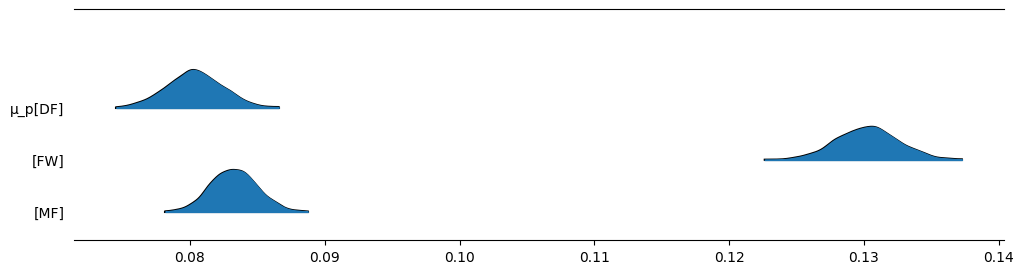

In [35]:
az.plot_forest(idata_sccr_ngk, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

In [36]:
az.rhat(idata_sccr_ngk)

<xarray.Dataset> Size: 40kB
Dimensions:  (θ_dim_0: 2517, pos: 3)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 20kB 0 1 2 3 4 5 ... 2511 2512 2513 2514 2515 2516
  * pos      (pos) <U2 24B 'DF' 'FW' 'MF'
Data variables:
    θ        (θ_dim_0) float64 20kB 1.0 1.003 1.001 1.006 ... 0.9998 1.004 1.005
    μ        float64 8B 1.002
    μ_p      (pos) float64 24B 1.009 1.002 1.002
    ν        float64 8B 1.003
    ν_p      (pos) float64 24B 1.077 1.008 1.013

**Task7**:

Compare the plot trace and that results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

The latter model was easier to run because the sparse GK was very confusing to the model, making it difficult to run. Now the numbers are much more in the accepted range, very close to 1. The curves are also tighter packed now. By doign this we were able to gain more accurate and condensed information regarding the other positions. However the new model does seem to be having some trouble with defenders, who also don't often score goals.